In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
import operator

def get_truth(inp, relate, cut):
    ops = {'>': operator.gt,
           '<': operator.lt,
           '>=': operator.ge,
           '<=': operator.le,
           '=': operator.eq}
    return ops[relate](inp, cut)

In [3]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings

warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [7]:
data = pd.read_csv('datasets/car_data.csv')
data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [54]:
data = pd.get_dummies(data, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 22 columns):
class             1728 non-null object
buying_high       1728 non-null uint8
buying_low        1728 non-null uint8
buying_med        1728 non-null uint8
buying_vhigh      1728 non-null uint8
maint_high        1728 non-null uint8
maint_low         1728 non-null uint8
maint_med         1728 non-null uint8
maint_vhigh       1728 non-null uint8
doors_2           1728 non-null uint8
doors_3           1728 non-null uint8
doors_4           1728 non-null uint8
doors_5more       1728 non-null uint8
persons_2         1728 non-null uint8
persons_4         1728 non-null uint8
persons_more      1728 non-null uint8
lug_boot_big      1728 non-null uint8
lug_boot_med      1728 non-null uint8
lug_boot_small    1728 non-null uint8
safety_high       1728 non-null uint8
safety_low        1728 non-null uint8
safety_med        1728 non-null uint8
dtypes: object(1), uint8(21)
memory usage: 49.0+ KB


-----
-----
-----
-----
## Split to train & test datasets

In [57]:
from sklearn import model_selection

In [61]:
array = data.values
X = array[:,1:]
Y = array[:,0]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [62]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_validation = le.fit_transform(Y_validation)

In [63]:
Y_train

array([2, 0, 0, ..., 2, 2, 2])

## Pomocne funkcie

In [64]:
import graphviz
from sklearn import tree

In [65]:
def viz_tree(clf, class_names, feature_names):
    tree_ = tree.export_graphviz(clf, out_file = None, filled=True, rounded=True, class_names=class_names, feature_names=feature_names)
    graph = graphviz.Source(tree_)
    return graph

-----
## Natrenovanie rozhodovacieho stromu

In [66]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

In [81]:
clf = DecisionTreeClassifier()

clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [82]:
pred = clf.predict(X_validation)

In [83]:
print(accuracy_score(Y_validation, pred))
print(classification_report(Y_validation, pred))

0.9826589595375722
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        77
           1       0.86      0.75      0.80         8
           2       0.99      1.00      0.99       246
           3       1.00      0.93      0.97        15

   micro avg       0.98      0.98      0.98       346
   macro avg       0.95      0.91      0.93       346
weighted avg       0.98      0.98      0.98       346



In [84]:
# Get attribute names
attr_names = data.columns.values[1:]

# Get class names
class_names = data['class'].unique()

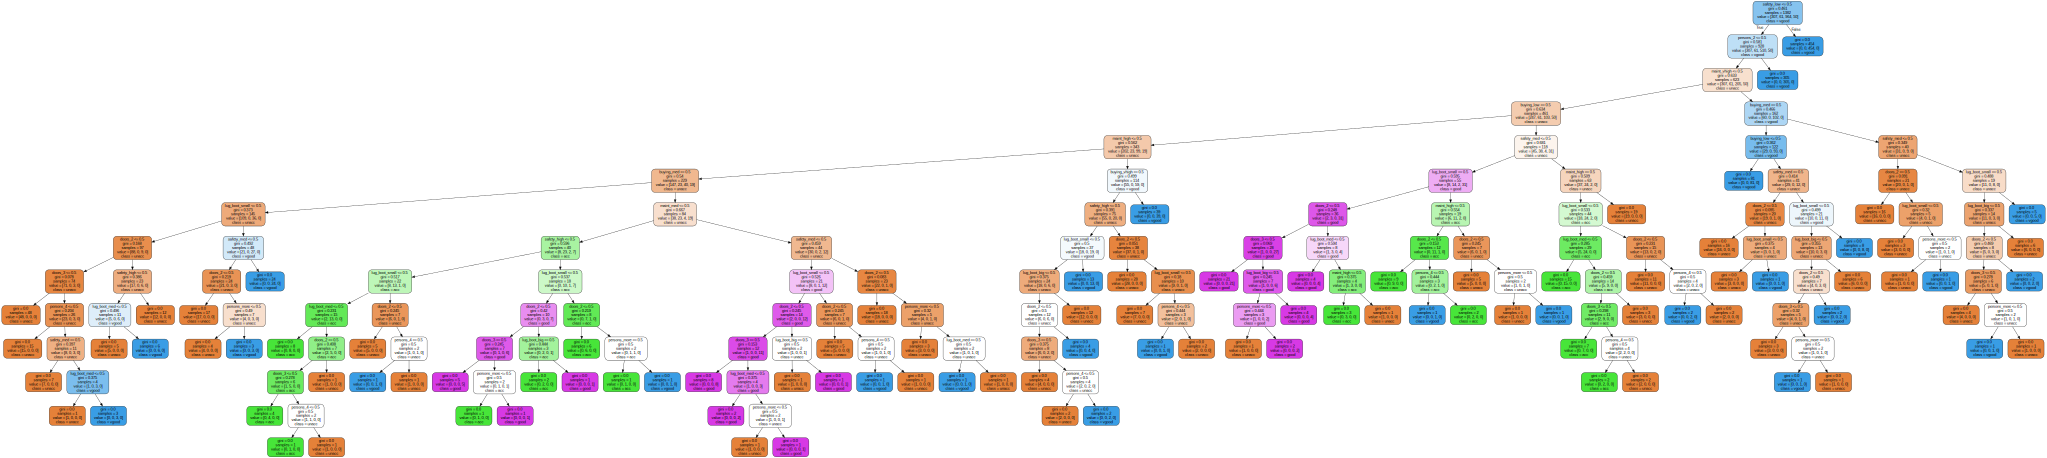

In [85]:
viz_tree(clf, class_names, attr_names)

-------
## Important classes for single tree interpretation

In [86]:
def get_leaf_class_name(class_names, node_values):
    max_value_index = 0
    max_value = 0
    for c, value in enumerate(node_values[0]):
        if value != 0 and value > max_value:
            max_value_index = c
            max_value = value
    
    return class_names[max_value_index]

        
def get_node_value(node_values):
    max_ = 0
    for c, value in enumerate(node_values[0]):
        if value > max_:
            max_ = value
            
    return max_
        
        
def get_paths_for(class_name, tree, cur_index, lst, paths, sign):
    if cur_index >= len(tree.children_left):
        return
    
    if len(lst) > 0 and cur_index != -1:
        lst[len(lst) - 1] = (lst[len(lst) - 1][0], lst[len(lst) - 1][1], sign, lst[len(lst) - 1][3])
        
    lst.append((cur_index, tree.feature[cur_index], sign, round(tree.threshold[cur_index], 2)))
    if cur_index != -1:
        get_paths_for(class_name, tree, tree.children_left[cur_index], lst, paths, '<=')
        get_paths_for(class_name, tree, tree.children_right[cur_index], lst, paths, '>')
    else:
        if get_leaf_class_name(data['class'].unique(), tree.value[list(lst[-2])[0]]) == class_name:
            paths.add(tuple(lst[:-1]))
        
    lst.pop()
    
    
def get_feature_value_pairs(tree, paths):
    
    pairs = []
    for path in paths:
        d = []
        features = tree.feature
        thresholds = tree.threshold

        for i, p in enumerate(list(path[:-1])):
            d.append((i, features[i], thresholds[i]))

        pairs.append(d)
        
    return pairs


def rule_predict(class_name, rule):
    pred = []
    
    for row in X_validation:
        
        valid = True
        for condition in rule[:-1]:
            condition = list(condition)
            
            if not get_truth(row[condition[1]], condition[2], condition[3]):
                valid = False
            
        if valid:
            pred.append(class_name)
        else:
            pred.append(-1)
            
    return pred


# Function which computes rule accuracy based. It makes a classification report and takes
# the precision value and returns it
def compute_rule_accuracy(class_name, rule):
    pred = rule_predict(class_name, rule)
    report = classification_report(pred, Y_validation, output_dict = True)
    
    return round(report[str(class_name)]['precision'], 2)


def prune_rule(class_name, rule):
    max_accuracy = 0
    final_rule = rule
    
    for i in range(len(rule[:-1])):
        accuracy = compute_rule_accuracy(class_name, rule[i:])
        
        if accuracy > max_accuracy:
            final_rule = rule[i:]
            max_accuracy = accuracy
           
    return (max_accuracy, tuple(final_rule))


def combine_rules(class_name, rf_model):
    rules = set()
    
    for estimator in rf_model.estimators_:
        get_paths_for(class_name, estimator.tree_, 0, [], rules, '<=')
        
    return rules


def get_class_index(class_name):
    for c, cls in enumerate(data['class'].unique()):
        if cls == class_name:
            return c
        
        
def get_rules_accuracy(class_name, rf_model, removeRedundancy = False):
    rules = combine_rules(class_name, rf_model)
    
    if removeRedundancy:
        rules = redundancy_condition_removal(rules)
    
    rules = list(rules)
    
    final_rules = set()
    for rule in rules:
        rule_ = [compute_rule_accuracy(get_class_index(class_name), rule), rule]
        final_rules.add(tuple(rule_))
        
    return sorted(list(final_rules), reverse=True, key=lambda x: list(x)[0])
    
        
def get_pruned_rules_accuracy(class_name, rf_model):
    rules = list(combine_rules(class_name, rf_model))
    
    final_rules = set()
    for rule in rules:
        pruned = prune_rule(get_class_index(class_name), list(rule))
        final_rules.add(tuple(pruned))
    
    return sorted(list(final_rules), reverse=True, key=lambda x: list(x)[0])


def redundancy_condition_removal(rule_set):
    output = set()
    
    for rule in list(rule_set):
        
        rule = list(rule)
        for i, cond in enumerate(rule[:-1]):
            cond = list(cond)
            
            for cond2 in rule[i + 1:-1]:
                cond2 = list(cond2)
                    
                if cond[1] == cond2[1] and cond[2] == cond2[2]:
                    if cond[2] == '>':
                        cond[3] = (cond[3] if cond[3] > cond2[3] else cond2[3])
                    else:
                        cond[3] = (cond[3] if cond[3] < cond2[3] else cond2[3])
                        
                    # Assign changed rule to condition
                    rule[i] = tuple(cond)
                    
                    # Remove redundant rule from list
                    rule.remove(tuple(cond2))
                
        output.add(tuple(rule))
        
    return output

In [87]:
rules_set = set()
get_paths_for("vgood", clf.tree_, 0, [], rules_set, '<=')
rules_set

{((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 1, '<=', 0.5),
  (4, 4, '<=', 0.5),
  (5, 2, '<=', 0.5),
  (6, 17, '<=', 0.5),
  (7, 8, '<=', 0.5),
  (8, 9, '>', 0.5),
  (10, 13, '>', 0.5),
  (12, 20, '>', 0.5),
  (14, 16, '>', 0.5),
  (16, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 1, '<=', 0.5),
  (4, 4, '<=', 0.5),
  (5, 2, '<=', 0.5),
  (6, 17, '<=', 0.5),
  (7, 8, '>', 0.5),
  (17, 18, '<=', 0.5),
  (18, 16, '>', 0.5),
  (20, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 1, '<=', 0.5),
  (4, 4, '<=', 0.5),
  (5, 2, '<=', 0.5),
  (6, 17, '>', 0.5),
  (22, 20, '<=', 0.5),
  (23, 8, '>', 0.5),
  (25, 14, '>', 0.5),
  (27, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 1, '<=', 0.5),
  (4, 4, '<=', 0.5),
  (5, 2, '<=', 0.5),
  (6, 17, '>', 0.5),
  (22, 20, '>', 0.5),
  (28, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  

In [88]:
len(rules_set)

27

In [89]:
rules_set = redundancy_condition_removal(rules_set)

In [91]:
rules_set

{((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 1, '<=', 0.5),
  (4, 4, '<=', 0.5),
  (5, 2, '<=', 0.5),
  (6, 17, '<=', 0.5),
  (7, 8, '<=', 0.5),
  (8, 9, '>', 0.5),
  (10, 13, '>', 0.5),
  (12, 20, '>', 0.5),
  (14, 16, '>', 0.5),
  (16, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 1, '<=', 0.5),
  (4, 4, '<=', 0.5),
  (5, 2, '<=', 0.5),
  (6, 17, '<=', 0.5),
  (7, 8, '>', 0.5),
  (17, 18, '<=', 0.5),
  (18, 16, '>', 0.5),
  (20, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 1, '<=', 0.5),
  (4, 4, '<=', 0.5),
  (5, 2, '<=', 0.5),
  (6, 17, '>', 0.5),
  (22, 20, '<=', 0.5),
  (23, 8, '>', 0.5),
  (25, 14, '>', 0.5),
  (27, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 1, '<=', 0.5),
  (4, 4, '<=', 0.5),
  (5, 2, '<=', 0.5),
  (6, 17, '>', 0.5),
  (22, 20, '>', 0.5),
  (28, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  

---
## Simplifikacia pravidiel jedneho stromu pouzijuc booleansku algebru

In [92]:
from sympy.logic import simplify_logic
from sympy.abc import x, y, z
from sympy import *
from sympy.logic.boolalg import Not, And, Or
from sympy.logic.inference import satisfiable

import uuid

In [93]:
def create_and_expression(rule):
    output = ""
    
    for i, condition in enumerate(list(rule)[:-1]):
        condition = list(condition)
        key = str(condition[1]) + str(condition[3])
        
        var = "A" + uuid.uuid4().hex[:6].upper()
        
        if key in rule_dict:
            if condition[2] != rule_dict[key][0]:
                output += "Not(" + rule_dict[key][1] + ")"
            else:
                output += rule_dict[key][1]
        else:
            expr = var + ' = ' + 'symbols(\'' + (str(condition[1]) + condition[2] + str(condition[3])) + '\')'
            exec(expr)
            
            rule_dict[key] = [condition[2], var]
            output += var
        
            # Also push to rule_dict where key is the variable name and value is the rule
            var_dict[var] = condition
        
        if len(list(rule)[:-1]) - 1 != i:
            output += " & "
        
    return "(" + output + ")"


def create_big_or_rule(rule_set):
    output = ""
    for i, rule in enumerate(list(rule_set)):
        output += create_and_expression(rule)
        
        if len(rule_set) - 1 != i:
            output += " | "
            
    return output


def print_final_rule(simplified_rule):
    simplified_rule = str(simplified_rule).split()
    
    final_rule = ""
    for el in simplified_rule:
        if el in ('&', '|'):
            final_rule += " " + el + " "
        else:
            if "~" in el:
                el = el.replace("~", "")
                el_ = el
                
                if "(" in el_:
                    el_ = el_.replace("(", "")
                
                if ")" in el_:
                    el_ = el_.replace(")", "")
                
                var = var_dict[str(el_)]
                if var[2] == '>':
                    var[2] = '<='
                else:
                    var[2] = '>'
                    
                var_dict[str(el_)] = var
            
            if "(" in el:
                el = el.replace("(", "")
                final_rule += "(" + str(tuple(var_dict[str(el)]))
                
            elif ")" in el:
                el = el.replace(")", "")
                final_rule += str(tuple(var_dict[str(el)])) + ")"
            
            else:
                final_rule += str(tuple(var_dict[str(el)]))
            
    return final_rule

In [ ]:
# Restart dictionaries
rule_dict = {}
var_dict = {}

# First create one big expression from all rules
simplified = sympify(create_big_or_rule(rules_set), evaluate=False)

# Then, apply simplification function to it.
l = simplify_logic(simplified)

# The print the final big rule, to interpret the decision three
print_final_rule(l)

In [95]:
sympify(create_big_or_rule(rules_set), evaluate=False)

~ADC1FD6 | (ADC1FD6 & ~A46AE3E) | (A46AE3E & ACF9603 & ADC1FD6 & ~A01791C & ~AD4B301) | (A46AE3E & ACF9603 & AD363BD & AD4B301 & ADC1FD6 & ~AAD9BD2) | (A01791C & A46AE3E & AB043C9 & ADC1FD6 & ~ABF7354 & ~AD4B301) | (A01791C & A46AE3E & A54E4AE & A8850B2 & AB043C9 & ABF7354 & ADC1FD6 & ~AD4B301) | (A46AE3E & A65E10E & AAD9BD2 & ACF9603 & AD363BD & AD4B301 & ADC1FD6 & ~ABF7354) | (A46AE3E & A54E4AE & A65E10E & A8850B2 & AAD9BD2 & ABF7354 & ACF9603 & AD363BD & AD4B301 & ADC1FD6) | (A46AE3E & AB043C9 & ADC1FD6 & ~A01791C & ~ABF7354 & ~ACF9603 & ~AD4B301) | (A01791C & A0ED5F6 & A46AE3E & A54E4AE & ADC1FD6 & ~AB043C9 & ~ABF7354 & ~AD4B301) | (A46AE3E & AB043C9 & ACF9603 & AD4B301 & ADC1FD6 & ~A01791C & ~ABF7354 & ~AD363BD) | (A0ED5F6 & A46AE3E & A54E4AE & AD363BD & AD4B301 & ADC1FD6 & ~AB043C9 & ~ABF7354 & ~ACF9603) | (A46AE3E & A54E4AE & A8850B2 & AB043C9 & ABF7354 & ADC1FD6 & ~A01791C & ~ACF9603 & ~AD4B301) | (A01791C & A0ED5F6 & A46AE3E & A54E4AE & A6F9A12 & AB043C9 & ACF9603 & AD4B301 & 

-----
## Natrenovanie random forestu

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [106]:
rfclf = RandomForestClassifier(n_estimators=5, max_depth=8)
rfclf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [107]:
pred = rfclf.predict(X_validation)

In [108]:
print(accuracy_score(Y_validation, pred))
print(classification_report(Y_validation, pred))

0.9132947976878613
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        77
           1       0.50      0.12      0.20         8
           2       0.97      0.96      0.96       246
           3       0.92      0.80      0.86        15

   micro avg       0.91      0.91      0.91       346
   macro avg       0.79      0.69      0.71       346
weighted avg       0.91      0.91      0.91       346



### Generate prunned rules for 'Iris-setosa' class and assign them accuracy

In [109]:
p = get_pruned_rules_accuracy("vgood", rfclf)
p

[(0.8, ((15, 11, '<=', 0.5), (16, -2, '<=', -2.0))),
 (0.8, ((55, 11, '<=', 0.5), (56, -2, '<=', -2.0))),
 (0.8, ((181, 14, '<=', 0.5), (182, -2, '<=', -2.0))),
 (0.8, ((22, 11, '<=', 0.5), (23, -2, '<=', -2.0))),
 (0.8, ((18, 11, '<=', 0.5), (19, -2, '<=', -2.0))),
 (0.78, ((45, 2, '<=', 0.5), (46, -2, '<=', -2.0))),
 (0.78, ((67, 2, '<=', 0.5), (68, -2, '<=', -2.0))),
 (0.78, ((127, 2, '<=', 0.5), (128, -2, '<=', -2.0))),
 (0.78, ((112, 10, '<=', 0.5), (113, -2, '<=', -2.0))),
 (0.78, ((94, 6, '<=', 0.5), (95, -2, '<=', -2.0))),
 (0.78, ((148, 10, '<=', 0.5), (149, -2, '<=', -2.0))),
 (0.78, ((183, 10, '<=', 0.5), (184, -2, '<=', -2.0))),
 (0.77, ((34, 1, '<=', 0.5), (35, -2, '<=', -2.0))),
 (0.77, ((132, 1, '<=', 0.5), (133, -2, '<=', -2.0))),
 (0.77, ((72, 1, '<=', 0.5), (73, -2, '<=', -2.0))),
 (0.76, ((40, 4, '<=', 0.5), (41, -2, '<=', -2.0))),
 (0.76, ((79, 20, '<=', 0.5), (80, -2, '<=', -2.0))),
 (0.76, ((43, 4, '<=', 0.5), (44, -2, '<=', -2.0))),
 (0.76, ((124, 5, '<=', 0.5), 

In [111]:
p2 = get_rules_accuracy("vgood", rfclf)
p2

[(0.52, ((0, 13, '<=', 0.5), (1, 12, '>', 0.5), (73, -2, '>', -2.0))),
 (0.5, ((0, 19, '>', 0.5), (78, -2, '>', -2.0))),
 (0.5, ((0, 19, '>', 0.5), (166, -2, '>', -2.0))),
 (0.33,
  ((0, 14, '<=', 0.5),
   (1, 18, '<=', 0.5),
   (2, 13, '<=', 0.5),
   (3, -2, '<=', -2.0))),
 (0.32, ((0, 19, '<=', 0.5), (1, 12, '>', 0.5), (77, -2, '>', -2.0))),
 (0.27,
  ((0, 3, '<=', 0.5),
   (1, 14, '<=', 0.5),
   (2, 19, '>', 0.5),
   (34, -2, '>', -2.0))),
 (0.25,
  ((0, 3, '<=', 0.5),
   (1, 14, '<=', 0.5),
   (2, 19, '<=', 0.5),
   (3, 12, '>', 0.5),
   (33, -2, '>', -2.0))),
 (0.19,
  ((0, 14, '<=', 0.5),
   (1, 18, '>', 0.5),
   (31, 13, '<=', 0.5),
   (32, -2, '<=', -2.0))),
 (0.17,
  ((0, 14, '<=', 0.5),
   (1, 18, '<=', 0.5),
   (2, 13, '>', 0.5),
   (4, 19, '>', 0.5),
   (30, -2, '>', -2.0))),
 (0.13,
  ((0, 13, '>', 0.5),
   (74, 3, '<=', 0.5),
   (75, 19, '>', 0.5),
   (135, -2, '>', -2.0))),
 (0.12,
  ((0, 19, '<=', 0.5),
   (1, 14, '<=', 0.5),
   (2, 5, '<=', 0.5),
   (3, 7, '<=', 0.5),


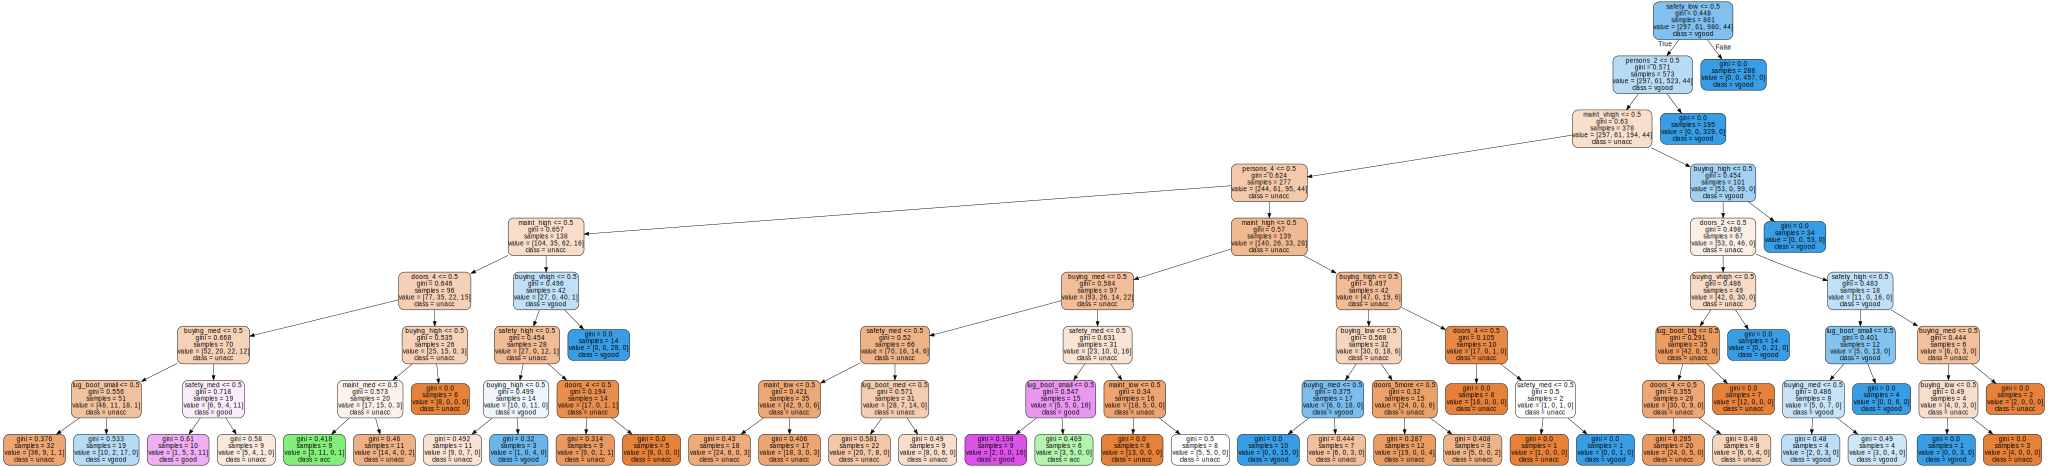

In [112]:
viz_tree(rfclf.estimators_[0], class_names, attr_names)

In [119]:
lst = []
t1_paths = set()

get_paths_for("vgood", rfclf.estimators_[0].tree_, 0, lst, t1_paths, '<=')
t1_paths

{((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 13, '<=', 0.5),
  (4, 4, '<=', 0.5),
  (5, 10, '<=', 0.5),
  (6, 2, '<=', 0.5),
  (7, 17, '>', 0.5),
  (9, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 13, '<=', 0.5),
  (4, 4, '>', 0.5),
  (18, 3, '<=', 0.5),
  (19, 18, '<=', 0.5),
  (20, 0, '>', 0.5),
  (22, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 13, '<=', 0.5),
  (4, 4, '>', 0.5),
  (18, 3, '>', 0.5),
  (26, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 13, '>', 0.5),
  (27, 4, '>', 0.5),
  (43, 0, '<=', 0.5),
  (44, 1, '<=', 0.5),
  (45, 2, '<=', 0.5),
  (46, -2, '<=', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 13, '>', 0.5),
  (27, 4, '>', 0.5),
  (43, 0, '>', 0.5),
  (51, 10, '>', 0.5),
  (53, 20, '>', 0.5),
  (55, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '>', 0.5)

In [120]:
redundancy_condition_removal(t1_paths)

{((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 13, '<=', 0.5),
  (4, 4, '<=', 0.5),
  (5, 10, '<=', 0.5),
  (6, 2, '<=', 0.5),
  (7, 17, '>', 0.5),
  (9, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 13, '<=', 0.5),
  (4, 4, '>', 0.5),
  (18, 3, '<=', 0.5),
  (19, 18, '<=', 0.5),
  (20, 0, '>', 0.5),
  (22, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 13, '<=', 0.5),
  (4, 4, '>', 0.5),
  (18, 3, '>', 0.5),
  (26, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 13, '>', 0.5),
  (27, 4, '>', 0.5),
  (43, 0, '<=', 0.5),
  (44, 1, '<=', 0.5),
  (45, 2, '<=', 0.5),
  (46, -2, '<=', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '<=', 0.5),
  (3, 13, '>', 0.5),
  (27, 4, '>', 0.5),
  (43, 0, '>', 0.5),
  (51, 10, '>', 0.5),
  (53, 20, '>', 0.5),
  (55, -2, '>', -2.0)),
 ((0, 19, '<=', 0.5),
  (1, 12, '<=', 0.5),
  (2, 7, '>', 0.5)

In [117]:
rule_dict = {}
var_dict = {}

sympify(create_big_or_rule(t1_paths))

~ABEE446 | (A06A038 & ABEE446) | (ABEE446 & ~A06A038 & ~ACDA431 & ~ADD2855) | (ABB32A4 & ABEE446 & ACDA431 & AF0D82E & ~A06A038 & ~A884C60) | (ABB32A4 & ABEE446 & ADD2855 & ~A06A038 & ~ACDA431 & ~AEB1499) | (A9DB223 & ABEE446 & ADD2855 & AE2BA0C & AEB1499 & ~A06A038 & ~ACDA431) | (A772AAD & A884C60 & A8E993E & ABEE446 & ACDA431 & ADD2855 & AF0D82E & ~A06A038) | (A288376 & A772AAD & ABEE446 & ACDA431 & AE2BA0C & ~A06A038 & ~A884C60 & ~AF0D82E) | (A772AAD & A8E993E & ABEE446 & ADD2855 & AEB1499 & ~A06A038 & ~A9DB223 & ~ACDA431) | (A772AAD & A9DB223 & ABEE446 & ADD2855 & AEB1499 & ~A06A038 & ~ACDA431 & ~AE2BA0C) | (A7B8F28 & A884C60 & ABEE446 & ACDA431 & AF0D82E & ~A06A038 & ~A288376 & ~ADD2855) | (A9DB223 & ABEE446 & ACDA431 & AF0D82E & ~A06A038 & ~A884C60 & ~ABB32A4 & ~ADD2855) | (A9DB223 & ABEE446 & ADD2855 & AEB1499 & ~A06A038 & ~A772AAD & ~ACDA431 & ~AE2BA0C)

In [114]:
rule_dict = {}
var_dict = {}

# Simplify rule sets for this rf tree
print_final_rule(simplify_logic(sympify(create_big_or_rule(t1_paths), evaluate=False)))

KeyboardInterrupt: 